In [ ]:
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Twitter api.csv to Twitter api.csv


In [ ]:
log = pd.read_csv('Twitter api.csv')

In [ ]:
log

,Key,Acess Token
0,Rajul twitter api access,724280722761064448-EXeSWtpIT8EeXVtFD706UYbMVcM...
1,Vcg9rWMcHLwXVd0RsS2IOuhQK,QXKrUVRxkbQzpiXGlSje6oZ0ZDPayseOqNWhhaJifHnVn
2,ncRzIkPSpPsP7L3RbxIYgvX6WWmW1KBKMC56wk5pIYJ5V1...,NaN
3,AAAAAAAAAAAAAAAAAAAAANeegQEAAAAA4cA%2F0uNVwDWQ...,NaN


In [ ]:
consumerKey = log['Key'][1]
consumerSecret = log['Key'][2]
accessToken = log['Acess Token'][0]
accessTokenSecret = log['Acess Token'][1]

In [ ]:
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)
authenticate.set_access_token(accessToken, accessTokenSecret)

api = tweepy.API(authenticate, wait_on_rate_limit=True)

Write to a csv file

In [ ]:
import csv

In [ ]:
csvFile = open('/content/drive/MyDrive/Coading files/Apple', 'a')
csvWriter = csv.writer(csvFile)
 
search_words = "Apple"      # enter your words
new_search = search_words + " -filter:retweets"
 
for tweet in tweepy.Cursor(api.search,q=new_search,count=100,
                           lang="en",
                           since_id=0).items():
                           csvWriter.writerow([tweet.created_at, tweet.text.encode('utf-8'),tweet.user.screen_name.encode('utf-8'), tweet.user.location.encode('utf-8')])

KeyboardInterrupt: ignored

In [ ]:
csvFile = open('/content/drive/MyDrive/Coading files/Pixel', 'a')
csvWriter = csv.writer(csvFile)
 
search_words = "Pixel"      # enter your words
new_search = search_words + " -filter:retweets"
 
for tweet in tweepy.Cursor(api.search,q=new_search,count=100,
                           lang="en",
                           since_id=0).items():
                           csvWriter.writerow([tweet.created_at, tweet.text.encode('utf-8'),tweet.user.screen_name.encode('utf-8'), tweet.user.location.encode('utf-8')])

In [ ]:
csvFile = open('/content/drive/MyDrive/Coading files/Xiaomi', 'a')
csvWriter = csv.writer(csvFile)
 
search_words = "Xiaomi"      # enter your words
new_search = search_words + " -filter:retweets"
 
for tweet in tweepy.Cursor(api.search,q=new_search,count=100,
                           lang="en",
                           since_id=0).items():
                           csvWriter.writerow([tweet.created_at, tweet.text.encode('utf-8'),tweet.user.screen_name.encode('utf-8'), tweet.user.location.encode('utf-8')])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Creating DataFrame from CSV

In [ ]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

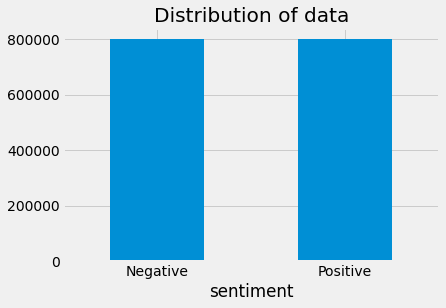

In [ ]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/content/drive/MyDrive/Coading files/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [ ]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
import nltk
nltk.download("stopwords") 
# from nltk.corpus import stopwords
from nltk.corpus import stopwords
stopwordlist = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)

        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
        
    return processedText

In [ ]:
import time
t = time.time()
# nltk.download('wordnet')
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 118 seconds


Analyzing the data

Wordcloud for negative tweets

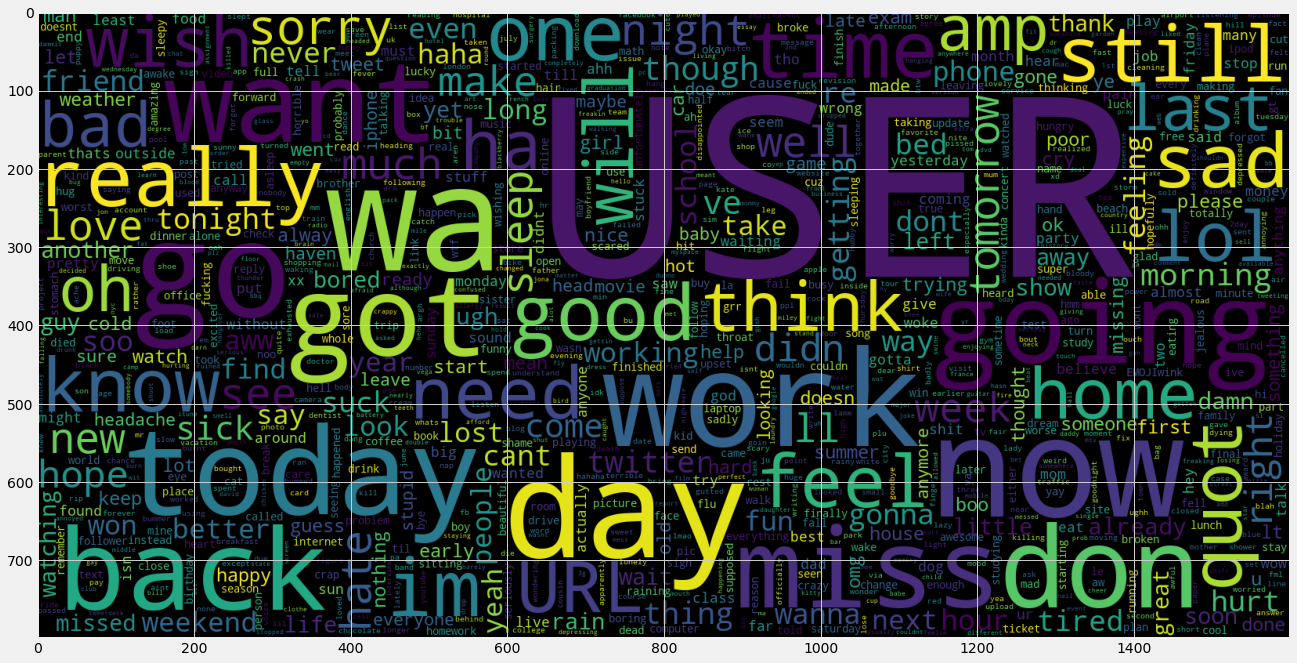

In [ ]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Wordcloud for positive tweets

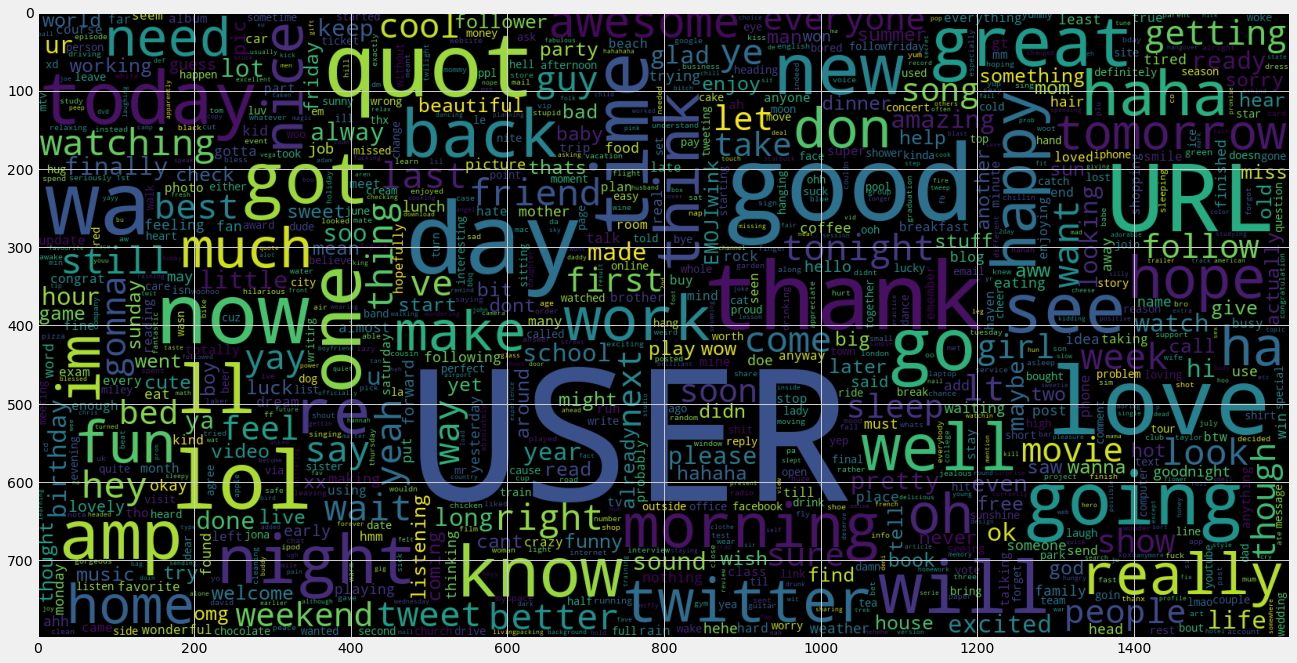

In [ ]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

Splitting data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


TF-IDF Vectoriser

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


Transforming the dataset

In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


Creating and Evaluating Models

We're creating 3 different types of model for our sentiment analysis problem:

Bernoulli Naive Bayes (BernoulliNB)
Linear Support Vector Classification (LinearSVC)
Logistic Regression (LR)

In [ ]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)
    
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

BernoulliNB Model

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



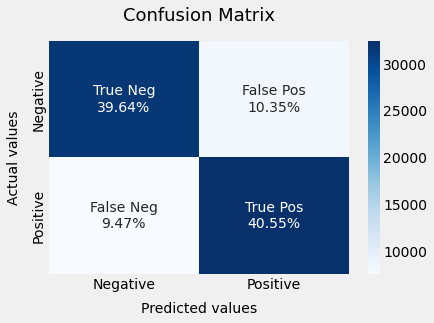

In [ ]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

LinearSVC Model

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



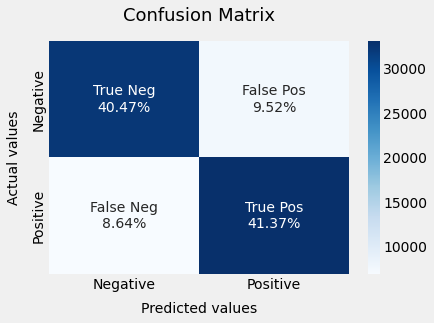

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

Logistic Regression Model

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



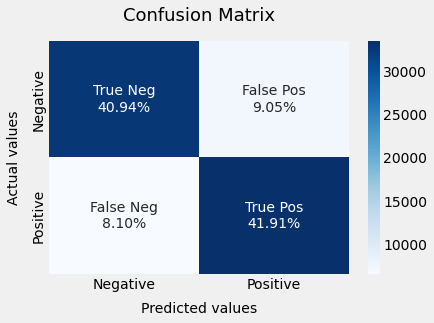

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

Saving the Models using Pickle

In [ ]:
file = open('/content/drive/MyDrive/Coading files/Sentiment-Vectoriser.pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('/content/drive/MyDrive/Coading files/Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('/content/drive/MyDrive/Coading files/Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

Using the model

In [ ]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('/content/drive/MyDrive/Coading files/Sentiment-Vectoriser.pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('/content/drive/MyDrive/Coading files/Sentiment-LR.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))

         # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    # Text to classify should be in a list.
    text = ["I hate twitter",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good"]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())

                              text sentiment
0                   I hate twitter  Negative
1       May the Force be with you.  Positive
2  Mr. Stark, I don't feel so good  Negative


In [ ]:
Sam = pd.read_csv('/content/drive/MyDrive/Coading files/Samsung')

In [ ]:
Sam.head()

,2022-08-28 10:27:44,b'@RjeyTech Samsung has always been winning',b'SatchmoORG',"b'Accra, Ghana'"
0,2022-08-28 10:27:38,b'We have beautiful Aso Oke for rent. Terms an...,b'AimahApparel',"b'Ibadan, Nigeria'"
1,2022-08-28 10:27:36,b'[Fancam] Aheye 4EVE - \xe0\xb8\xa7\xe0\xb8\x...,b'foryour_09',b'foraye \xf0\x9f\x8c\xb9\xf0\x9f\x90\x87'
2,2022-08-28 10:27:20,b'@SamsungIndia I buy Samsung au 8000 55-inch ...,b'NItishkmishra',"b'delhi ,pune'"
3,2022-08-28 10:27:07,"b'Samsung better than any other phone,go argue...",b'alpaty_',b''
4,2022-08-28 10:27:04,b'Samsung is outpacing Apple in the smartwatch...,b'bhavik_bhavsar',b'india'


In [ ]:
Sam.columns = ['time','Tweet','User','Place']

In [ ]:
Sam.head()

,time,Tweet,User,Place
0,2022-08-28 10:27:38,b'We have beautiful Aso Oke for rent. Terms an...,b'AimahApparel',"b'Ibadan, Nigeria'"
1,2022-08-28 10:27:36,b'[Fancam] Aheye 4EVE - \xe0\xb8\xa7\xe0\xb8\x...,b'foryour_09',b'foraye \xf0\x9f\x8c\xb9\xf0\x9f\x90\x87'
2,2022-08-28 10:27:20,b'@SamsungIndia I buy Samsung au 8000 55-inch ...,b'NItishkmishra',"b'delhi ,pune'"
3,2022-08-28 10:27:07,"b'Samsung better than any other phone,go argue...",b'alpaty_',b''
4,2022-08-28 10:27:04,b'Samsung is outpacing Apple in the smartwatch...,b'bhavik_bhavsar',b'india'


In [ ]:
col = ['time','User','Place']
Sam.drop(col,axis = 1,inplace = True)

In [ ]:
import time
t = time.time()
# nltk.download('wordnet')
Sam['Processed_Tweets'] = preprocess(Sam['Tweet'])
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 7 seconds


In [ ]:
Sam.head()

,Tweet,Processed_Tweets
0,b'We have beautiful Aso Oke for rent. Terms an...,we have beautiful aso oke for rent term and co...
1,b'[Fancam] Aheye 4EVE - \xe0\xb8\xa7\xe0\xb8\x...,fancam aheye 4eve xe0 xb8 xa7 xe0 xb8 xb1 xe0 ...
2,b'@SamsungIndia I buy Samsung au 8000 55-inch ...,USER buy samsung au 800 55 inch television and...
3,"b'Samsung better than any other phone,go argue...",samsung better than any other phone go argue w...
4,b'Samsung is outpacing Apple in the smartwatch...,samsung is outpacing apple in the smartwatch m...


In [ ]:
if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    # Text to classify should be in a list.
    text = Sam['Processed_Tweets']
    
    Sam_Sentiment = predict(vectoriser, LRmodel, text)
    print(Sam_Sentiment.head())

                                                text sentiment
0  we have beautiful aso oke for rent term and co...  Positive
1  fancam aheye 4eve xe0 xb8 xa7 xe0 xb8 xb1 xe0 ...  Positive
2  USER buy samsung au 800 55 inch television and...  Negative
3  samsung better than any other phone go argue w...  Positive
4  samsung is outpacing apple in the smartwatch m...  Positive


In [ ]:
Sam_Sentiment['sentiment'].value_counts()

Positive    49198
Negative    20687
Name: sentiment, dtype: int64

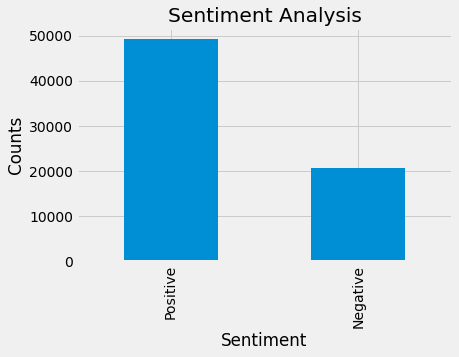

In [ ]:
# Plotting and visualizing the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
Sam_Sentiment['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

In [ ]:
# Print the percentage of negative tweets
ntweets = Sam_Sentiment[Sam_Sentiment.sentiment == 'Positive']
ntweets = ntweets['text']
ntweets

round( (ntweets.shape[0] / Sam_Sentiment.shape[0]) * 100, 1)

70.4

In [ ]:
# Print the percentage of negative tweets
ntweets = Sam_Sentiment[Sam_Sentiment.sentiment == 'Negative']
ntweets = ntweets['text']
ntweets

round( (ntweets.shape[0] / Sam_Sentiment.shape[0]) * 100, 1)

29.6

Loading and analysing Apple's dataset

In [ ]:
Apple = pd.read_csv('/content/drive/MyDrive/Coading files/Apple')

In [ ]:
Apple.columns = ['time','Tweet','User','Place']

In [ ]:
col = ['time','User','Place']
Apple.drop(col, axis = 1, inplace = True)

In [ ]:
Apple.head()

,Tweet
0,b'LIKE COME ONNNNN https://t.co/H0ZHLQj1oL'
1,"b""Kaitlyn Aurelia Smith / Let's Turn It Into S..."
2,"b""Every night I have the same old dream\n It's..."
3,b'Make real money by walking with @cashforstep...
4,"b""@Jessekwhitley Here's the start of a song\nT..."


In [ ]:
import time
t = time.time()
# nltk.download('wordnet')
Apple['Processed_Tweets'] = preprocess(Apple['Tweet'])
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 19 seconds


In [ ]:
Apple.head()

,Tweet,Processed_Tweets
0,b'LIKE COME ONNNNN https://t.co/H0ZHLQj1oL',like come onn URL
1,"b""Kaitlyn Aurelia Smith / Let's Turn It Into S...",kaitlyn aurelia smith let turn it into sound URL
2,"b""Every night I have the same old dream\n It's...",every night have the same old dream it the day...
3,b'Make real money by walking with @cashforstep...,make real money by walking with USER cashforst...
4,"b""@Jessekwhitley Here's the start of a song\nT...",USER here the start of song nthere more where ...


In [ ]:
if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    # Text to classify should be in a list.
    text = Apple['Processed_Tweets']
    
    Apple_Sentiment = predict(vectoriser, LRmodel, text)
    print(Apple_Sentiment.head())

                                                text sentiment
0                                 like come onn URL   Positive
1  kaitlyn aurelia smith let turn it into sound URL   Positive
2  every night have the same old dream it the day...  Negative
3  make real money by walking with USER cashforst...  Positive
4  USER here the start of song nthere more where ...  Positive


In [ ]:
Apple_Sentiment['sentiment'].value_counts()

Positive    162063
Negative     52789
Name: sentiment, dtype: int64

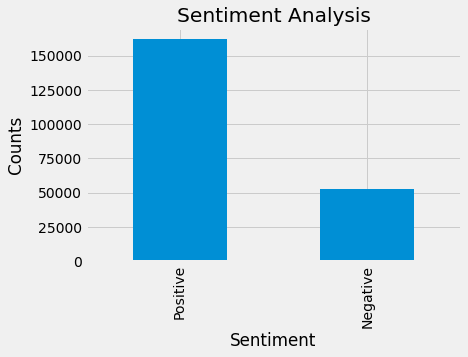

In [ ]:
# Plotting and visualizing the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
Apple_Sentiment['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

In [ ]:
# Print the percentage of negative tweets
ntweets = Apple_Sentiment[Apple_Sentiment.sentiment == 'Positive']
ntweets = ntweets['text']
ntweets

round( (ntweets.shape[0] / Apple_Sentiment.shape[0]) * 100, 1)

75.4

In [ ]:
# Print the percentage of negative tweets
ntweets = Apple_Sentiment[Apple_Sentiment.sentiment == 'Negative']
ntweets = ntweets['text']
ntweets

round( (ntweets.shape[0] / Apple_Sentiment.shape[0]) * 100, 1)

24.6

## **JUST FOR FUN**

Importing textblob for Comparison

In [ ]:
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
Sam.head()

,Tweet,Processed_Tweets
0,b'We have beautiful Aso Oke for rent. Terms an...,we have beautiful aso oke for rent term and co...
1,b'[Fancam] Aheye 4EVE - \xe0\xb8\xa7\xe0\xb8\x...,fancam aheye 4eve xe0 xb8 xa7 xe0 xb8 xb1 xe0 ...
2,b'@SamsungIndia I buy Samsung au 8000 55-inch ...,USER buy samsung au 800 55 inch television and...
3,"b'Samsung better than any other phone,go argue...",samsung better than any other phone go argue w...
4,b'Samsung is outpacing Apple in the smartwatch...,samsung is outpacing apple in the smartwatch m...


In [ ]:
# Create a function to get the subjectivity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity

# Create two new columns 'Subjectivity' & 'Polarity'
Sam_Sentiment['Subjectivity'] = Sam['Processed_Tweets'].apply(getSubjectivity)
Sam_Sentiment['Polarity'] = Sam['Processed_Tweets'].apply(getPolarity)

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
Sam_Sentiment.head()

,text,sentiment,Subjectivity,Polarity
0,we have beautiful aso oke for rent term and co...,Positive,0.7500,0.6750
1,fancam aheye 4eve xe0 xb8 xa7 xe0 xb8 xb1 xe0 ...,Positive,0.0000,0.0000
2,USER buy samsung au 800 55 inch television and...,Negative,0.7000,0.4000
3,samsung better than any other phone go argue w...,Positive,0.4375,0.1875
4,samsung is outpacing apple in the smartwatch m...,Positive,0.0000,0.0000


In [ ]:
def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'
Sam_Sentiment['Analysis'] = Sam_Sentiment['Polarity'].apply(getAnalysis)
# Show the dataframe
Sam_Sentiment.head()

,text,sentiment,Subjectivity,Polarity,Analysis
0,we have beautiful aso oke for rent term and co...,Positive,0.7500,0.6750,Positive
1,fancam aheye 4eve xe0 xb8 xa7 xe0 xb8 xb1 xe0 ...,Positive,0.0000,0.0000,Neutral
2,USER buy samsung au 800 55 inch television and...,Negative,0.7000,0.4000,Positive
3,samsung better than any other phone go argue w...,Positive,0.4375,0.1875,Positive
4,samsung is outpacing apple in the smartwatch m...,Positive,0.0000,0.0000,Neutral


In [ ]:
Sam_Sentiment['Analysis'].value_counts()

Neutral     33015
Positive    29244
Negative     7626
Name: Analysis, dtype: int64

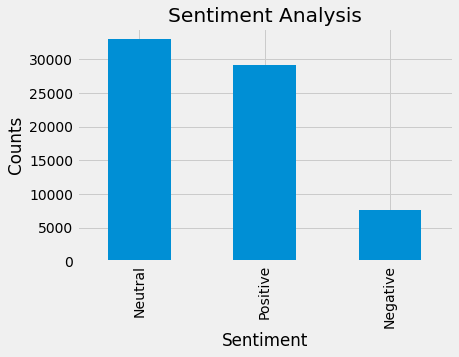

In [ ]:
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
Sam_Sentiment['Analysis'].value_counts().plot(kind = 'bar')
plt.show()